# **Overfitting**

Overfitting adalah situasi dimana sebuah model memiliki performa yang bagus saat mengenali data latih, namun performanya buruk saat mengenali data-data baru yang belum pernah ditemuinya.

## **Mencegah Overfitting**

## **Dropout**

Dropout adalah standar umum di industri yang dipakai untuk mencegah overfitting. Seperti yang kita ketahui, semakin kompleks sebuah model ML, maka akan semakin tinggi kemungkinan model tersebut mengalami overfitting. Dropout bekerja dengan mengurangi kompleksitas model jst tanpa merubah arsitektur model tersebut. 

Nama dropout mengacu pada unit/perseptron yang di-dropout (dibuang) secara temporer pada sebuah layer. Contohnya seperti di bawah di mana besaran dropout yang dipilih adalah 0.5 sehingga 50% dari persepteron hidden layer kedua dimatikan secara berkala pada saat pelatihan.

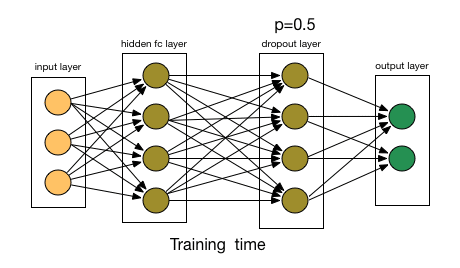

Weight dari setiap neuron pada sebuah layer bersifat statis. Hal ini menyebabkan jaringan saraf terlalu menyesuaikan dengan data latih sehingga overfitting. Nah, penerapan dropout akan membantu mengatasi hal ini. Untuk informasi lebih lanjut dapat Anda baca pada tautan berikut ya.

Untuk menggunakan dropout kita cukup menambahkan layer tf.keras.layers.Dropout() dan mengisi parameter berupa persentase dropout yang kita inginkan seperti di bawah. Dropout akan otomatis diaplikasikan pada layer yang mendahuluinya.

In [ ]:
import pandas as pd
df = pd.read_csv('SPAM text message.csv')

In [ ]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# melakukan proses one-hot-encoding karena "label" berupa data kategorikal
category = pd.get_dummies(df.Category)
df_baru = pd.concat([df, category], axis=1)

In [ ]:
df_baru.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
 2   ham       5572 non-null   uint8 
 3   spam      5572 non-null   uint8 
dtypes: object(2), uint8(2)
memory usage: 98.1+ KB


In [ ]:
# mengubah nilai-nilai dari dataframe ke dalam tipe data numpy array menggunakan atribut values
pesan = df_baru['Message'].values
label = df_baru[['ham', 'spam']].values
df_baru = df_baru.drop(columns='Category')
df_baru


,Message,ham,spam
0,"Go until jurong point, crazy.. Available only ...",1,0
1,Ok lar... Joking wif u oni...,1,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,0,1
3,U dun say so early hor... U c already then say...,1,0
4,"Nah I don't think he goes to usf, he lives aro...",1,0
...,...,...,...
5567,This is the 2nd time we have tried 2 contact u...,0,1
5568,Will ü b going to esplanade fr home?,1,0
5569,"Pity, * was in mood for that. So...any other s...",1,0
5570,The guy did some bitching but I acted like i'd...,1,0


In [ ]:
# bagi data untuk training dan data untuk testing
from sklearn.model_selection import train_test_split
pesan_latih, pesan_test, label_latih, label_test = train_test_split(pesan, label, test_size=0.2)


In [ ]:
#  ubah setiap kata pada dataset ke dalam bilangan numerik dengan fungsi Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
 
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(pesan_latih) 
tokenizer.fit_on_texts(pesan_test)


# mengonversi setiap sampel menjadi sequence 
sekuens_latih = tokenizer.texts_to_sequences(pesan_latih)
sekuens_test = tokenizer.texts_to_sequences(pesan_test)
 
padded_latih = pad_sequences(sekuens_latih) 
padded_test = pad_sequences(sekuens_test)

In [ ]:
#  menggunakan layer Embedding dengan dimensi embedding sebesar 16
# dimensi dari input sebesar nilai num_words pada objek tokenizer

import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),              # hiden layer 1
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),               # hiden layer 2
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation='softmax')
])


# panggil fungsi compile dan tentukan optimizer serta loss function
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          80000     
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 128)        41472     
 nal)                                                            
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 512)               66048     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)              

## **Callbacks**

Fungsi callback adalah memberi tahu model kita untuk berhenti ketika telah mencapai akurasi tertentu sehingga proses pelatihan model menjadi lebih singkat.

In [ ]:
# fungsi callback untuk menghentikan epoch apabila akurasi sudah mencapai 98%
class toCallback(tf.keras.callbacks.Callback): 
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.98 and logs.get('accuracy')==1.00):
      print("Proses Training Berhenti, Tingkat Akurasi Sudah Lebih Dari 98%")
      self.model.stop_training = True

callbacks= toCallback()

# **Batch Loading**

Batch loading adalah proses pelatihan dimana jst melakukan pembaruan parameternya (weight) setelah membaca sejumlah sampel data tertentu.

Misal dataset kita berisi 800 buah gambar pizza. Tanpa batch size, proses pembaruan parameter terjadi untuk seluruh sampel pada dataset. Sehingga ketika tanpa menggunakan batch size, pada 1 epoch terdapat 800 kali pembaruan weight. Ketika 1 ukuran batch adalah 32 buah gambar pizza, maka terdapat 25 buah batch pada dataset. Pada batch loading, model baru melakukan pembaruan parameter setelah membaca satu batch atau 32 buah gambar pizza. Sehingga proses pembaruan parameter pada 1 epoch hanya sebanyak 25 kali.

Dengan batch loading proses pelatihan data menjadi jauh lebih cepat. Kita akan melihat langsung kegunaan dari batch loading dengan latihan di bawah.

Untuk menggunakan batch loading kita hanya tinggal menambahkan parameter ‘batch_size’ pada fungsi fit(). Tahukah Anda bahwa fungsi fit() secara default menggunakan batch loading dengan batch size sebesar 32. Lantas ketika kita tidak mendefinisikan parameter batch_size, maka ukuran batch akan diisi sebesar 32 secara default. Perhatikan bahwa pada setiap epoch memakan waktu selama sekitar 3 atau 4 detik.

In [ ]:
#mulai melatih model dengan memanggil fungsi fit()
num_epochs = 30
latih = model.fit(padded_latih, label_latih, epochs=num_epochs,
                  validation_data=(padded_test, label_test), verbose=2, 
                  )


Epoch 1/30
140/140 - 24s - loss: 0.0050 - accuracy: 0.9975 - val_loss: 0.0993 - val_accuracy: 0.9865 - 24s/epoch - 174ms/step
Epoch 2/30
140/140 - 23s - loss: 0.0061 - accuracy: 0.9980 - val_loss: 0.0682 - val_accuracy: 0.9839 - 23s/epoch - 166ms/step
Epoch 3/30
140/140 - 23s - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.0871 - val_accuracy: 0.9857 - 23s/epoch - 166ms/step
Epoch 4/30
140/140 - 23s - loss: 1.0494e-04 - accuracy: 1.0000 - val_loss: 0.1026 - val_accuracy: 0.9865 - 23s/epoch - 166ms/step
Epoch 5/30
140/140 - 23s - loss: 1.1678e-05 - accuracy: 1.0000 - val_loss: 0.1047 - val_accuracy: 0.9892 - 23s/epoch - 166ms/step
Epoch 6/30
140/140 - 23s - loss: 8.9157e-06 - accuracy: 1.0000 - val_loss: 0.1074 - val_accuracy: 0.9901 - 23s/epoch - 166ms/step
Epoch 7/30
140/140 - 23s - loss: 6.8937e-06 - accuracy: 1.0000 - val_loss: 0.1103 - val_accuracy: 0.9901 - 23s/epoch - 165ms/step
Epoch 8/30
140/140 - 25s - loss: 2.9053e-06 - accuracy: 1.0000 - val_loss: 0.1119 - val_accuracy: 0.99

In [ ]:
# mulai melatih model dengan memanggil fungsi fit()
num_epochs = 30
latih = model.fit(padded_latih, label_latih, epochs=num_epochs, batch_size=256,
                  validation_data=(padded_test, label_test), verbose=2, 
                  callbacks=[callbacks]) # memanggil fungsi callback


Epoch 1/30
18/18 - 28s - loss: 0.4931 - accuracy: 0.8510 - val_loss: 0.3930 - val_accuracy: 0.8717 - 28s/epoch - 2s/step
Epoch 2/30
18/18 - 14s - loss: 0.3918 - accuracy: 0.8645 - val_loss: 0.3539 - val_accuracy: 0.8717 - 14s/epoch - 793ms/step
Epoch 3/30
18/18 - 14s - loss: 0.2910 - accuracy: 0.8645 - val_loss: 0.1802 - val_accuracy: 0.8717 - 14s/epoch - 775ms/step
Epoch 4/30
18/18 - 15s - loss: 0.1536 - accuracy: 0.9204 - val_loss: 0.0983 - val_accuracy: 0.9865 - 15s/epoch - 855ms/step
Epoch 5/30
18/18 - 16s - loss: 0.0464 - accuracy: 0.9897 - val_loss: 0.0386 - val_accuracy: 0.9928 - 16s/epoch - 897ms/step
Epoch 6/30
18/18 - 18s - loss: 0.0170 - accuracy: 0.9942 - val_loss: 0.0503 - val_accuracy: 0.9865 - 18s/epoch - 1s/step
Epoch 7/30
18/18 - 14s - loss: 0.0083 - accuracy: 0.9975 - val_loss: 0.0527 - val_accuracy: 0.9874 - 14s/epoch - 775ms/step
Epoch 8/30
18/18 - 18s - loss: 0.0047 - accuracy: 0.9987 - val_loss: 0.0444 - val_accuracy: 0.9892 - 18s/epoch - 976ms/step
Epoch 9/30
18/